In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
from functools import partial
import matplotlib


In [2]:
def second_order_derivative(f, x0, rtol=1e-3, atol=1e-4, max_iter=20):
    h = 1e-3
    derivative_old = 0.0
    print('\n')
    for i in range(max_iter):
        h /= 2
        derivative_new = (f(x0 + h) - 2 * f(x0) + f(x0 - h)) / h**2
        print(derivative_new)
        if np.abs(derivative_new - derivative_old) < rtol*np.abs(derivative_old):
            return derivative_new
        derivative_old = derivative_new
    raise ValueError("Convergence not reached within the maximum number of iterations")

def get_frequency(flux,EJ,EC,EL,i,j):
    qbt = scqubits.Fluxonium(EJ = EJ,EC = EC,EL =EL, cutoff = 110,flux = flux,truncated_dim=20)
    vals = qbt.eigenvals()
    return np.abs(vals[j]-vals[i])


hbar = 1/(2*np.pi)
kB = 8.617333262e-5  # eV K−1
hbar_in_eVs = 6.5821e-16  # eV s
temp_in_mK = 20

def diel_spectral_density(omega, EC,temp_in_mK = 20 ,Q_cap = 1e5):
    beta = 1 / (kB * temp_in_mK * 1e-3)  # 1/eV

    x = beta * hbar_in_eVs * omega # s GHZ
    x *= 1e9  # dimensionless
    return_val = 1/2 * np.abs( 1 / np.tanh(x/ 2) + 1) 

    return_val *= hbar * np.abs(omega)**2   / (4 * EC * Q_cap)  # GHZ^2/GHZ = GHZ
    return return_val

def one_over_f_spectral_density(omega, EL,one_over_f_flux_noise_amplitude ):
    return_val = 2 * np.pi # dimensionless
    return_val *= (EL / hbar)**2  # GHz^2
    return_val *= one_over_f_flux_noise_amplitude**2  # GHz^2
    return_val /= omega  # GHz
    return np.abs(return_val)

def T_phi(second_order_derivative, one_over_f_flux_noise_amplitude):  # eqn (13) of Peter Groszkowski et al 2018 New J. Phys. 20 043053
    omega_uv = 3 * 2 * np.pi  # GHz
    omega_ir = 1e-9 * 2 * np.pi  # GHz
    t = 10e3  # ns
    A = one_over_f_flux_noise_amplitude  # in unit of Phi0
    return_val = 2 * A**4 * second_order_derivative**2  # Phi0^4 GHZ^2 / Phi0^4
    return_val *= (np.log(omega_uv / omega_ir)**2 + 2 * np.log(omega_ir * t)**2)  # GHZ^2
    return_val = return_val**(-1/2)  # ns
    return return_val  


EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL

UIFQ = scqubits.Fluxonium(EJ = EJ,EC = EJ/EJoverEC,EL = EJ/EJoverEL, cutoff =110,flux = 0,truncated_dim=20)
UIFQ_element = np.abs(UIFQ.matrixelement_table('phi_operator',evals_count=3)[1,2]) 
UIFQ_freq = (UIFQ.eigenvals()[2]-UIFQ.eigenvals()[1]) * 2 * np.pi
UIFQ_derivative = second_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=1,j=2),x0=0)

IFQ_element = np.abs(UIFQ.matrixelement_table('phi_operator',evals_count=3)[0,1]) 
IFQ_freq = (UIFQ.eigenvals()[1]-UIFQ.eigenvals()[0]) * 2 * np.pi
IFQ_derivative =  second_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=0,j=1),x0=0)

conventional_qbt = scqubits.Fluxonium(EJ = EJ,EC = EJ/EJoverEC,EL = EJ/EJoverEL, cutoff = 110,flux = 0.5,truncated_dim=20)
phi_conventional = np.abs(conventional_qbt.matrixelement_table('phi_operator',evals_count=3)[0,1])
conventional_qbt_freq = (conventional_qbt.eigenvals()[1]-conventional_qbt.eigenvals()[0])  * 2 * np.pi
conventional_derivative = second_order_derivative(partial(get_frequency, EJ = EJ,EC = EJ/EJoverEC,EL=EJ/EJoverEL,i=0,j=1),x0=0.5)

def get_lifetimes_in_ms(Q_cap, one_over_f_flux_noise_amplitude): 
    UIFQ_dielectric_lifetime = 1 / (np.abs(UIFQ_element)**2 * diel_spectral_density(UIFQ_freq, EC,temp_in_mK,Q_cap)) / 1e6
    UIFQ_one_over_f_loss_lifetime = 1 / (np.abs(UIFQ_element)**2 * one_over_f_spectral_density(UIFQ_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    UIFQ_dephasing_lifetime = T_phi(UIFQ_derivative, one_over_f_flux_noise_amplitude) / 1e6

    IFQ_dielectric_lifetime = 1 / (np.abs(IFQ_element)**2 * diel_spectral_density(IFQ_freq, EC,temp_in_mK,Q_cap)) / 1e6
    IFQ_one_over_f_loss_lifetime = 1 / (np.abs(IFQ_element)**2 * one_over_f_spectral_density(IFQ_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    IFQ_dephasing_lifetime = T_phi(IFQ_derivative, one_over_f_flux_noise_amplitude) / 1e6

    conventional_dielectric_lifetime = 1 / (np.abs(phi_conventional)**2 * diel_spectral_density(conventional_qbt_freq, EC,temp_in_mK,Q_cap  )) / 1e6
    conventional_one_over_f_loss_lifetime = 1 / (np.abs(phi_conventional)**2 * one_over_f_spectral_density(conventional_qbt_freq, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    conventional_dephasing_lifetime = T_phi(conventional_derivative, one_over_f_flux_noise_amplitude) / 1e6

    return UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, UIFQ_dephasing_lifetime, \
        IFQ_dielectric_lifetime, IFQ_one_over_f_loss_lifetime, IFQ_dephasing_lifetime,\
        conventional_dielectric_lifetime, conventional_one_over_f_loss_lifetime, conventional_dephasing_lifetime



18070.798899590736
22017.559324929436
23673.55482408584
24171.28804654567
24302.39538443857
24335.619100384065
24343.953493371373


-9035.647795620605
-11009.028006810695
-11837.025755880859
-12085.892360801154
-12151.446016105183
-12168.057859526016
-12172.224436653778


895.5474186844725
897.2314443980167
897.654435348727


In [3]:
phi_conventional,UIFQ_element

(2.9671347664903833, 5.900809835630914)

In [4]:
conventional_qbt_freq,UIFQ_freq

(0.1400891872520857, 0.020433194786376646)

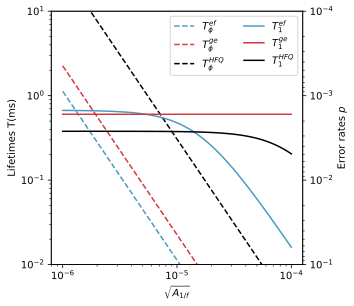

In [7]:
array_of_one_over_f_flux_noise_amplitude = np.linspace(np.log10(1e-6),
                                  np.log10(1e-4),
                                  100)
array_of_one_over_f_flux_noise_amplitude = 10**array_of_one_over_f_flux_noise_amplitude

fig = plt.figure(figsize=(5, 4.3)) 
gs = fig.add_gridspec(nrows=1, ncols=1,left=0.15, right=0.85,bottom=0.15,top = 0.97)
ax = fig.add_subplot(gs[0])

Q_cap = 1e5
UIFQ_diel_T1_array = []

UIFQ_T1_array = []
UIFQ_Tphi_array = []
UIFQ_T2_array = []

IFQ_T1_array = []
IFQ_Tphi_array = []
IFQ_T2_array = []

conventional_T1_array = []
conventional_Tphi_array = []
conventional_T2_array = []

for mu in array_of_one_over_f_flux_noise_amplitude:

    UIFQ_dielectric_lifetime, UIFQ_one_over_f_loss_lifetime, UIFQ_dephasing_lifetime, \
        IFQ_dielectric_lifetime, IFQ_one_over_f_loss_lifetime, IFQ_dephasing_lifetime,\
        conventional_dielectric_lifetime, conventional_one_over_f_loss_lifetime, conventional_dephasing_lifetime = get_lifetimes_in_ms(Q_cap, mu)

    UIFQ_T1 =1/(1/UIFQ_dielectric_lifetime + 1/UIFQ_one_over_f_loss_lifetime)
    UIFQ_T2 = 1/ (1/(2*UIFQ_T1) + 1/UIFQ_dephasing_lifetime)

    IFQ_T1 =1/(1/IFQ_dielectric_lifetime + 1/IFQ_one_over_f_loss_lifetime)
    IFQ_T2 = 1/ (1/(2*IFQ_T1) + 1/IFQ_dephasing_lifetime)

    conventional_T1 =1/(1/conventional_dielectric_lifetime + 1/conventional_one_over_f_loss_lifetime)
    conventional_T2 = 1/ (1/(2*conventional_T1) + 1/conventional_dephasing_lifetime)
    
    UIFQ_T1_array.append(UIFQ_T1)
    UIFQ_Tphi_array.append(UIFQ_dephasing_lifetime)
    UIFQ_T2_array.append(UIFQ_T2)

    IFQ_T1_array.append(IFQ_T1)
    IFQ_Tphi_array.append(IFQ_dephasing_lifetime)
    IFQ_T2_array.append(IFQ_T2)

    conventional_T1_array.append(conventional_T1)
    conventional_Tphi_array.append(conventional_dephasing_lifetime)
    conventional_T2_array.append(conventional_T2)

ax.plot(array_of_one_over_f_flux_noise_amplitude, UIFQ_Tphi_array, color= '#4999c3',label = rf'$T_\phi^{{ef}}$',linestyle='--')
ax.plot(array_of_one_over_f_flux_noise_amplitude, IFQ_Tphi_array, color= '#d5373d',label = rf'$T_\phi^{{ge}}$',linestyle='--')
ax.plot(array_of_one_over_f_flux_noise_amplitude, conventional_Tphi_array, color= 'black',label = rf'$T_\phi^{{HFQ}}$',linestyle='--')

ax.plot(array_of_one_over_f_flux_noise_amplitude, UIFQ_T1_array, color= '#4999c3',label = rf'$T_1^{{ef}}$',linestyle='-')
ax.plot(array_of_one_over_f_flux_noise_amplitude, IFQ_T1_array, color= '#d5373d',label = rf'$T_1^{{ge}}$',linestyle='-')
ax.plot(array_of_one_over_f_flux_noise_amplitude, conventional_T1_array, color= 'black',label = rf'$T_1^{{HFQ}}$',linestyle='-')

ymin = 1e-2
ymax = 1e1
ax.set_ylim(ymin, ymax)
ax2 = ax.twinx()
ax2.set_ylabel(r'Error rates $p$')
ax2.set_ylim(1e-3/ymin,1e-3/ymax)
ax2.set_yscale('log')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\sqrt{A_{1/f}}$')
ax.set_ylabel(r'Lifetimes T(ms)')
ax.legend(ncol = 2,loc='upper right')

fig.savefig('ef_T2_vs_1_over_f.pdf')
